In [1]:
import logging
from utility import add_project_root_to_path

logging.basicConfig(level=logging.ERROR)

add_project_root_to_path()

In [2]:
# Building experiments configs

from experiments.configs import DATA_SOURCE_BY_ALIAS, DEFAULT_UNINFORMED_USERS_CONFIG
from experiments.experiment import Experiment
from user.informed_user import InformedUser

from fee_algorithm.fixed_fee import FixedFee
from fee_algorithm.discrete_fee_perfect_oracle import DiscreteFeePerfectOracle
# from fee_algorithm.continuous_fee_perfect_oracle import ContinuousFeePerfectOracle
# from fee_algorithm.fee_based_on_historical_price import FeeBasedOnHistoricalPrice
from fee_algorithm.based_on_trade_count_fee import BasedOnTradeCountFee
from fee_algorithm.adaptive_fee_based_on_block_price_move import AdaptiveBasedOnPreviousBlockPriceMoveFee
from experiments.run_multiple_experiments import run_multiple_experiments, get_experiment_key


from copy import deepcopy

fee_algos_to_consider = {
    "FX_fee": FixedFee(exchange_fee_rate=0.003), # 30 bps
    # "based_on_trade_count_fee": BasedOnTradeCountFee(a_to_b_exchange_fee_rate=0.003, b_to_a_exchange_fee_rate=0.003), # 30 bps
    "BA_fee": AdaptiveBasedOnPreviousBlockPriceMoveFee(a_to_b_exchange_fee_rate=0.003, b_to_a_exchange_fee_rate=0.003), # 30 bps
    "OB_fee": DiscreteFeePerfectOracle(fee_rate_in_arbitrage_direction=0.0045, fee_rate_in_non_arbitrage_direction=0.0015), # 45/15 bps
    # "continuous_fee_perfect_oracle": ContinuousFeePerfectOracle(default_fee_rate=0.003), # 30 bps
    # "fee_based_on_historical_price": FeeBasedOnHistoricalPrice(alpha=0.3, fee_in_increasing_deviation_direction=0.0045, fee_in_decreasing_deviation_direction=0.0015), # 45/15 bps
}

experiment_configs = {}


for period_alias in DATA_SOURCE_BY_ALIAS.keys():
    data_source = DATA_SOURCE_BY_ALIAS[period_alias]
    for fee_algo_alias, fee_algo in fee_algos_to_consider.items():
        experiment_configs[
            get_experiment_key(
                {
                    "period_alias": period_alias,
                    "fee_algorithm": fee_algo_alias,
                }
            )
        ] = Experiment(
            data=data_source,
            fee_algorithm=deepcopy(fee_algo),
            uninformed_users=deepcopy(DEFAULT_UNINFORMED_USERS_CONFIG),
            informed_user=InformedUser(),
        )

In [3]:
fee_algorithm_sample = list(fee_algos_to_consider.keys())[0]

In [4]:
from pprint import pprint

pprint(experiment_configs[
    get_experiment_key(
        {
        "period_alias": "volatile_market",
        "fee_algorithm": fee_algorithm_sample,
    })
])

Experiment(data=HistoricalDataDescription(start_time=datetime.datetime(2024, 3, 1, 12, 0),
                                          end_time=datetime.datetime(2024, 3, 31, 12, 0),
                                          A_symbol='ETH',
                                          B_symbol='SHIB',
                                          stable_coin_symbol='USDT',
                                          candle_interval='1m'),
           fee_algorithm=FixedFee(exchange_fee_rate=0.003),
           informed_user=InformedUser(),
           uninformed_users=UninformedUsersConfig(uninformed_user=UninformedUser(mu=0.00016,
                                                                                 sigma=1e-05),
                                                  probability_of_trade=0.5,
                                                  n_users=1),
           initial_pool_value=25000000,
           network_fee=5,
           random_seed=0)


In [5]:
print(
    f"Total experiments to run: {len(experiment_configs)}"
)

Total experiments to run: 12


In [6]:
experiment_results = run_multiple_experiments(
    experiments=experiment_configs,
    parallel=True,
    max_workers=16,
)

Running Experiments: 100%|██████████| 12/12 [00:48<00:00,  4.05s/it]


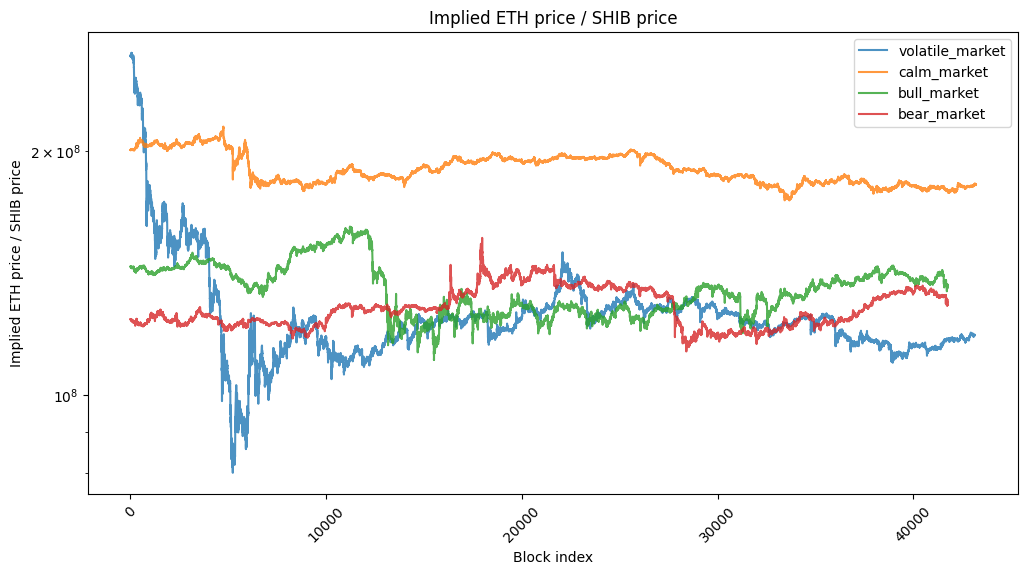

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

A_symbol = None
B_symbol = None
stable_coin_symbol = None

for period_alias in DATA_SOURCE_BY_ALIAS.keys():
    experiment_key = get_experiment_key({
        "period_alias": period_alias,
        "fee_algorithm": fee_algorithm_sample,
    })
    data_source = DATA_SOURCE_BY_ALIAS[period_alias]
    if A_symbol is None:
        A_symbol = data_source.A_symbol
    if B_symbol is None:
        B_symbol = data_source.B_symbol
    if stable_coin_symbol is None:
        stable_coin_symbol = data_source.stable_coin_symbol

    assert A_symbol == data_source.A_symbol
    assert B_symbol == data_source.B_symbol
    assert stable_coin_symbol == data_source.stable_coin_symbol
    experiment_result = experiment_results[experiment_key]
    price_ratio = experiment_result.data["price_A"] / experiment_result.data["price_B"]
    plt.plot(price_ratio, label=period_alias, alpha=0.8)

plt.title(f"Implied {A_symbol} price / {B_symbol} price")
plt.ylabel(f"Implied {A_symbol} price / {B_symbol} price")
plt.xlabel("Block index")
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.yscale("log")
plt.show()

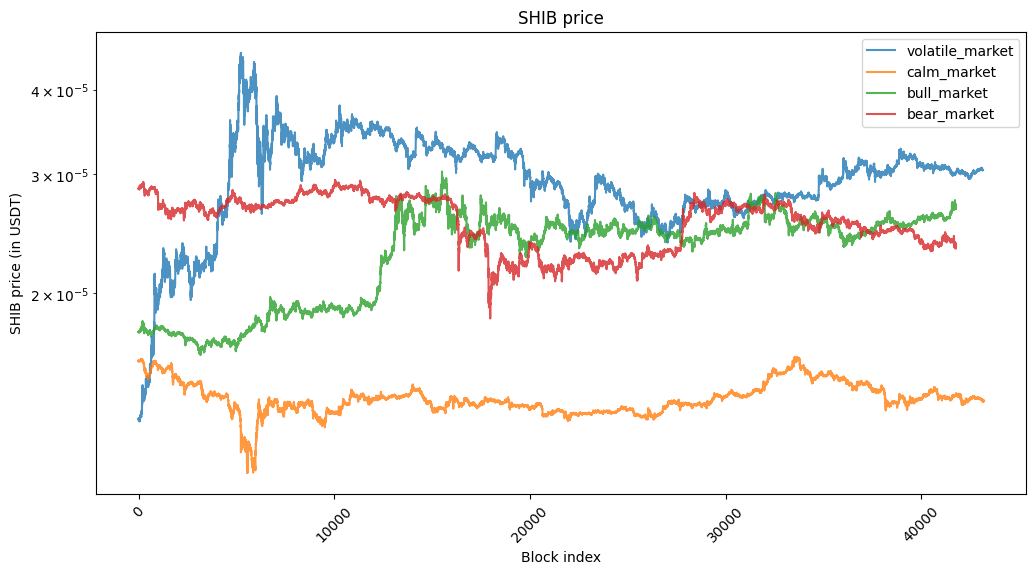

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for period_alias in DATA_SOURCE_BY_ALIAS.keys():
    experiment_result = experiment_results[
        get_experiment_key(
            {
                "period_alias": period_alias,
                "fee_algorithm": fee_algorithm_sample
            }
        )
    ]
    plt.plot(experiment_result.data["price_B"], label=period_alias, alpha=0.8)
    plt.title(f"{B_symbol} price")

plt.ylabel(f"{B_symbol} price (in {stable_coin_symbol})")
plt.xlabel("Block index")
plt.yscale("log")

plt.xticks(rotation=45)

plt.legend(loc="upper right")

plt.show()

### Results

In [9]:
from visualizations.compare_fee_algoritms import plot_participants_markouts, plot_impermanent_loss, get_experiments_summary_by_alias

In [10]:
def plot_results_for_period(period_alias: str, fee_algos_to_consider: list[str]):
    map_by_fee_algo = {
        fee_algo_alias: experiment_results[
            get_experiment_key(
                {
                    "period_alias": period_alias,
                    "fee_algorithm": fee_algo_alias,
                }
            )
        ]
        for fee_algo_alias in fee_algos_to_consider
    }
    plot_participants_markouts(
        period_alias,
        map_by_fee_algo,
    )
    plot_impermanent_loss(
        period_alias,
        map_by_fee_algo,
    )

    summary = get_experiments_summary_by_alias(
        map_by_fee_algo
    )

    display(summary)

### Results for bull market

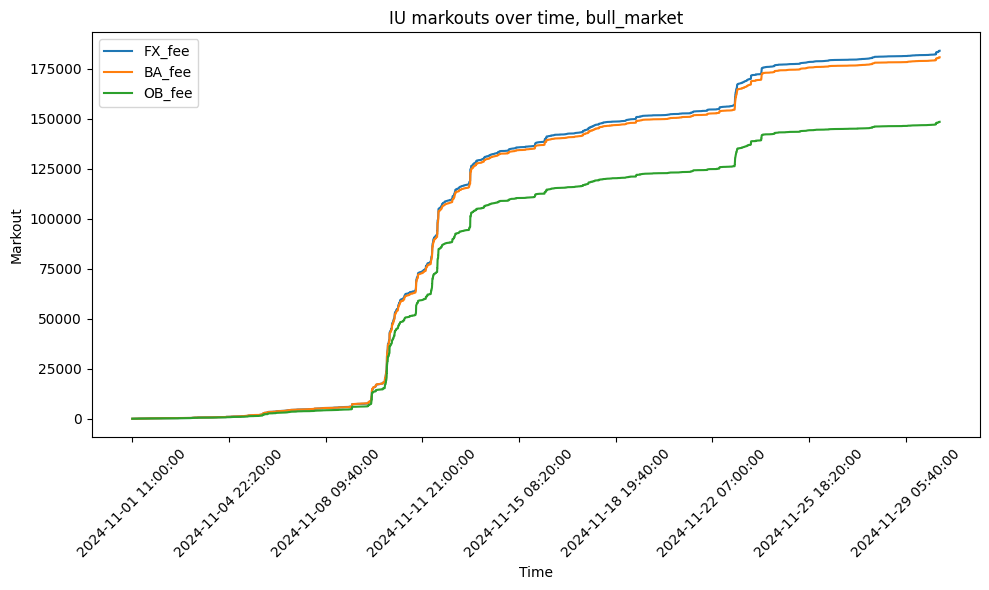

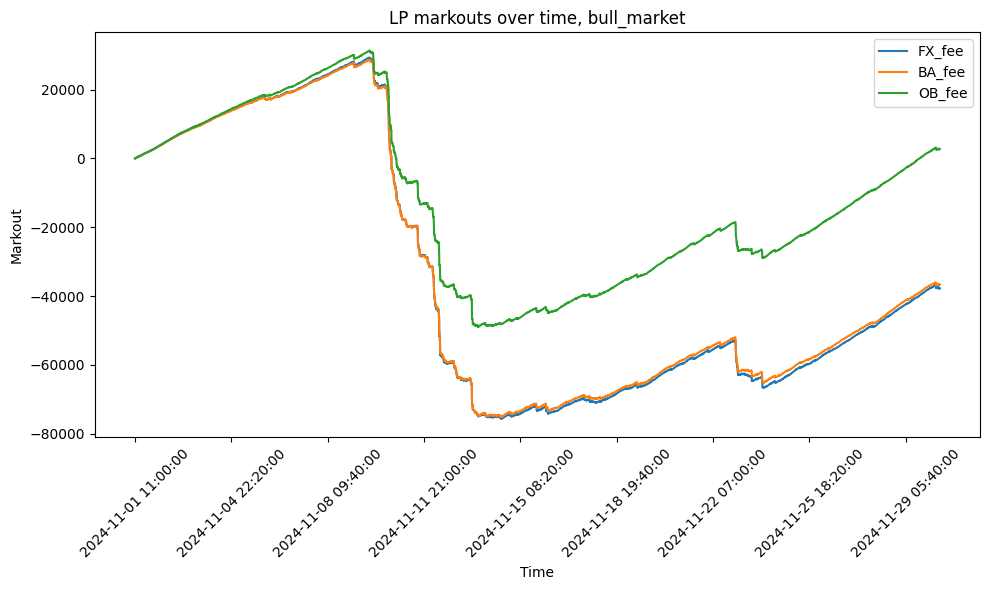

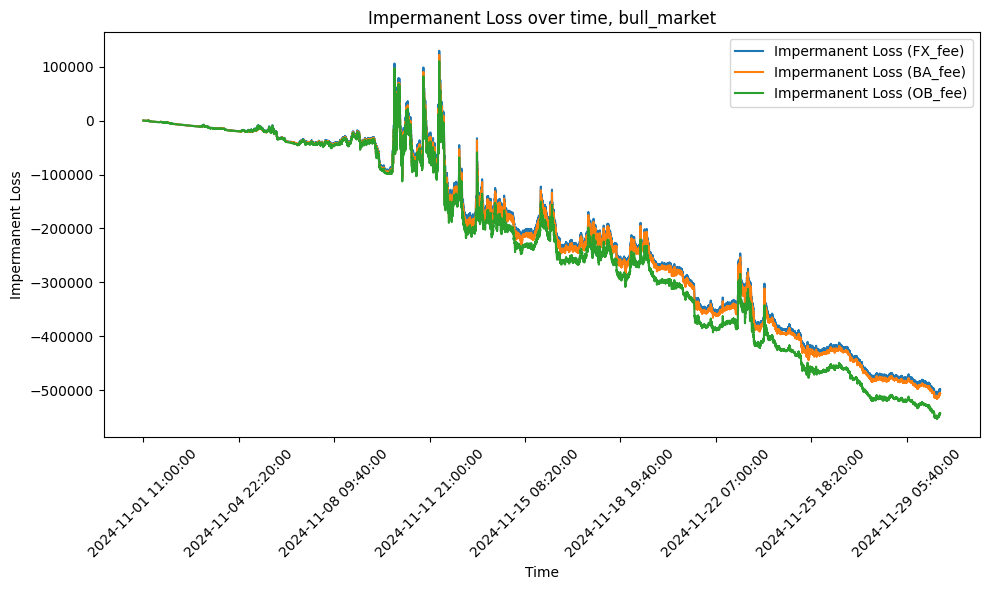

,experiment_name,iu_markout,iu_trade_count,iu_yield,uu_markout,uu_trade_count,uu_yield,lp_markout,lp_yield,impermanent_loss
0,FX_fee,183885.20,4459,18.83,-272719.97,20864,-51.53,-37780.23,-2.51,-497942.00
1,BA_fee,180638.61,4392,18.81,-269787.73,20782,-51.25,-36720.88,-2.47,-505209.70
2,OB_fee,148359.50,3243,20.07,-271359.24,20813,-51.43,2719.73,0.21,-541722.54


In [11]:
bull_market_summary = plot_results_for_period("bull_market", list(fee_algos_to_consider.keys()))

### Results for calm market

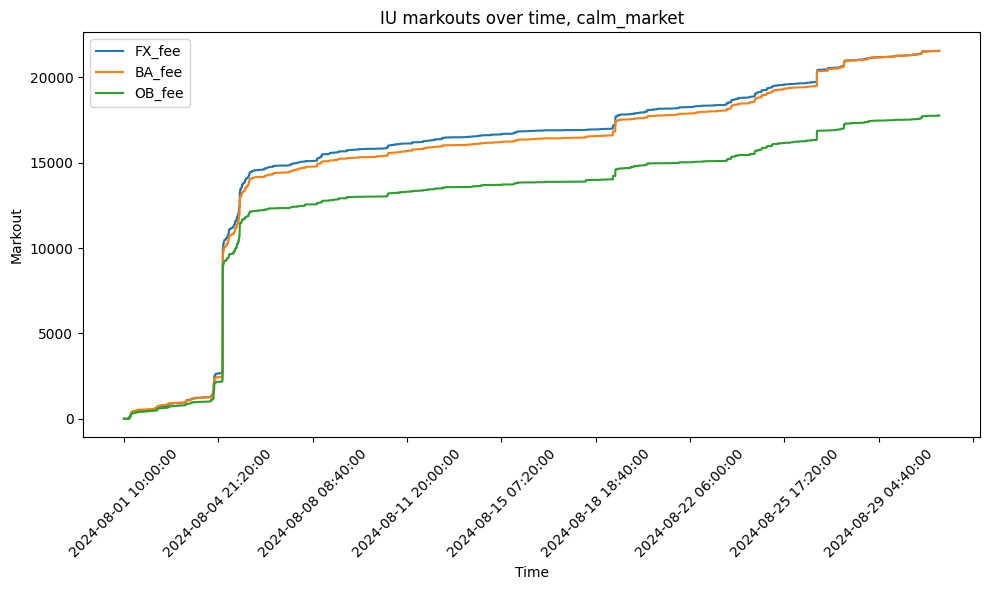

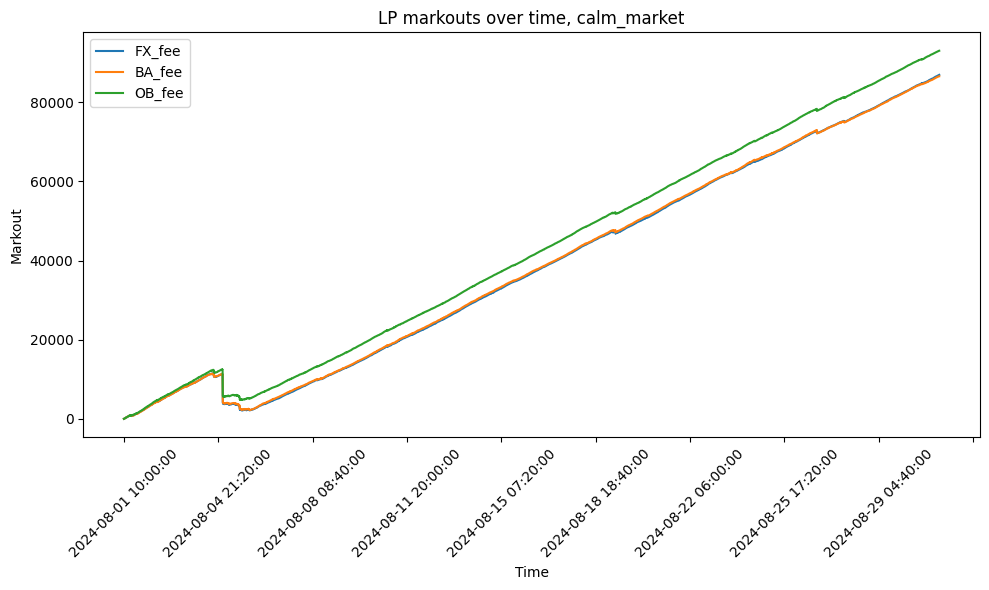

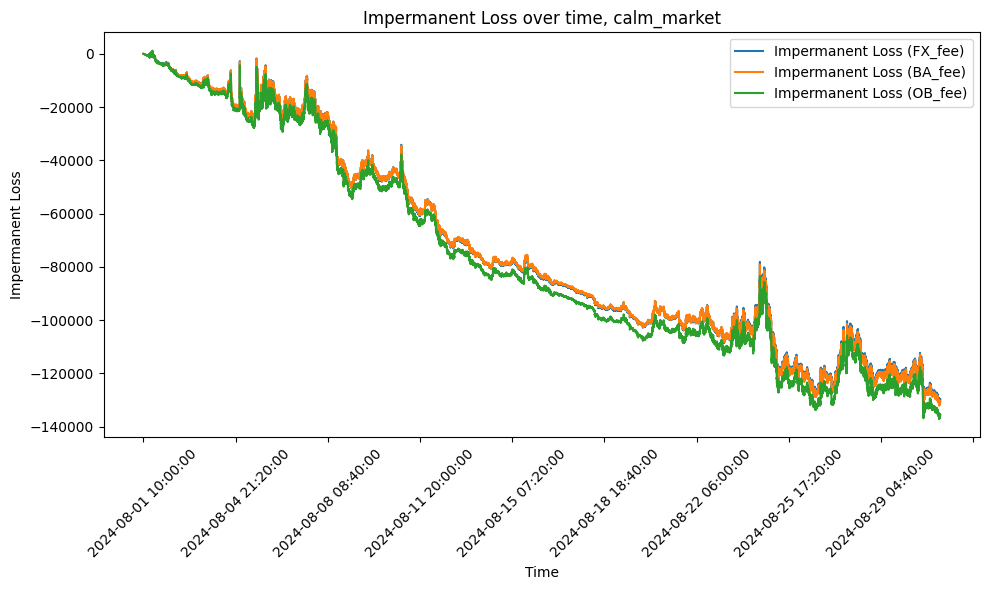

,experiment_name,iu_markout,iu_trade_count,iu_yield,uu_markout,uu_trade_count,uu_yield,lp_markout,lp_yield,impermanent_loss
0,FX_fee,21547.33,1388,13.23,-222801.41,21478,-60.79,86924.08,16.42,-129736.31
1,BA_fee,21556.81,1449,12.86,-222935.93,21510,-60.70,86584.12,16.19,-130465.17
2,OB_fee,17768.01,1016,14.58,-223127.23,21453,-60.91,93014.22,19.05,-135422.48


In [12]:
calm_market_summary = plot_results_for_period("calm_market", list(fee_algos_to_consider.keys()))

### Results for bear market

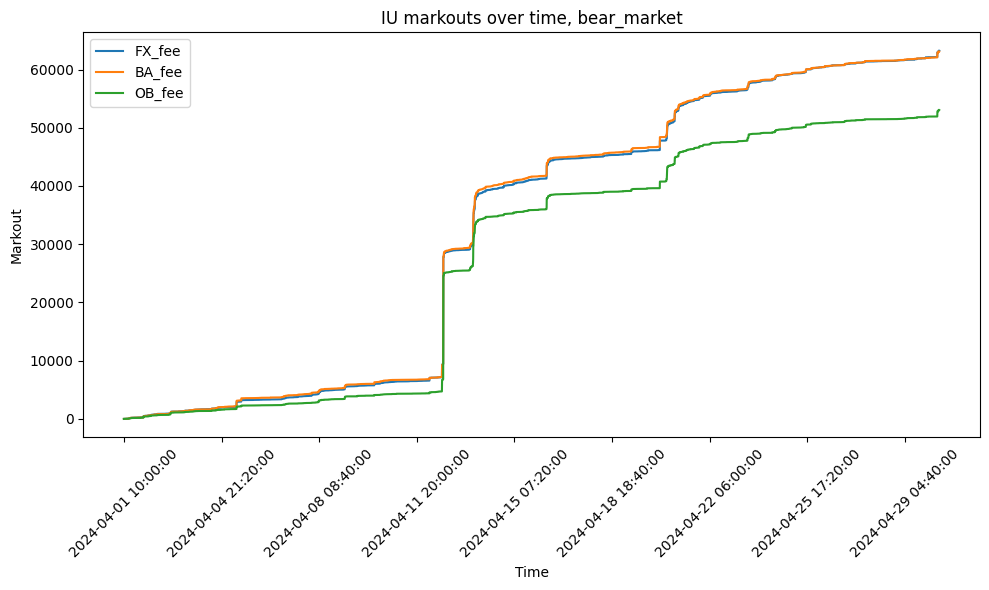

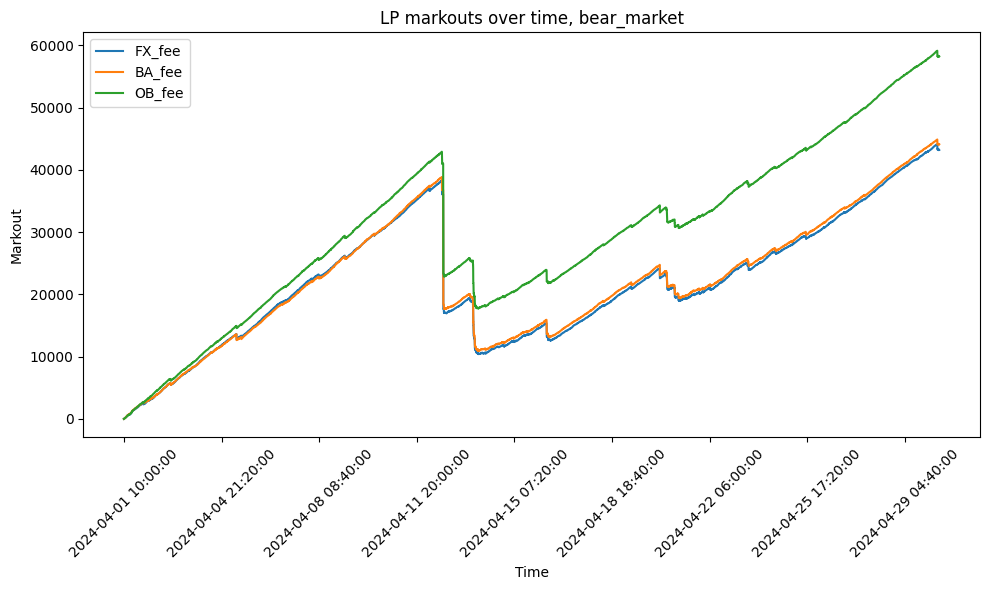

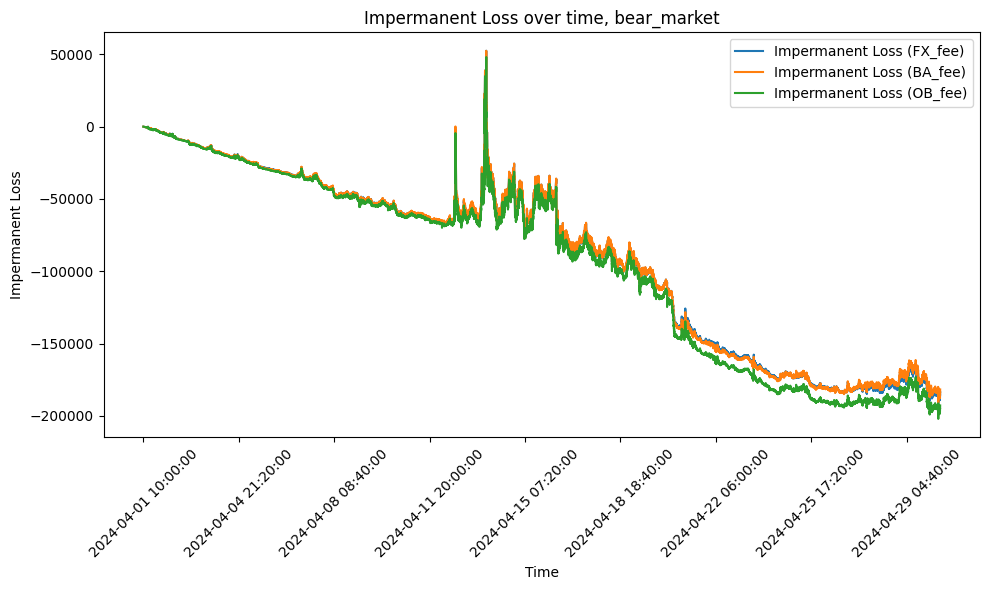

,experiment_name,iu_markout,iu_trade_count,iu_yield,uu_markout,uu_trade_count,uu_yield,lp_markout,lp_yield,impermanent_loss
0,FX_fee,63221.84,2199,20.63,-221016.89,20718,-59.09,43210.05,6.35,-183518.44
1,BA_fee,63081.51,2208,20.66,-222167.81,20784,-59.21,44126.30,6.48,-181757.01
2,OB_fee,53033.05,1538,23.61,-222756.76,20756,-59.46,58253.71,9.72,-192817.69


In [13]:
bear_market_summary = plot_results_for_period("bear_market", list(fee_algos_to_consider.keys()))

### Results for volatile market

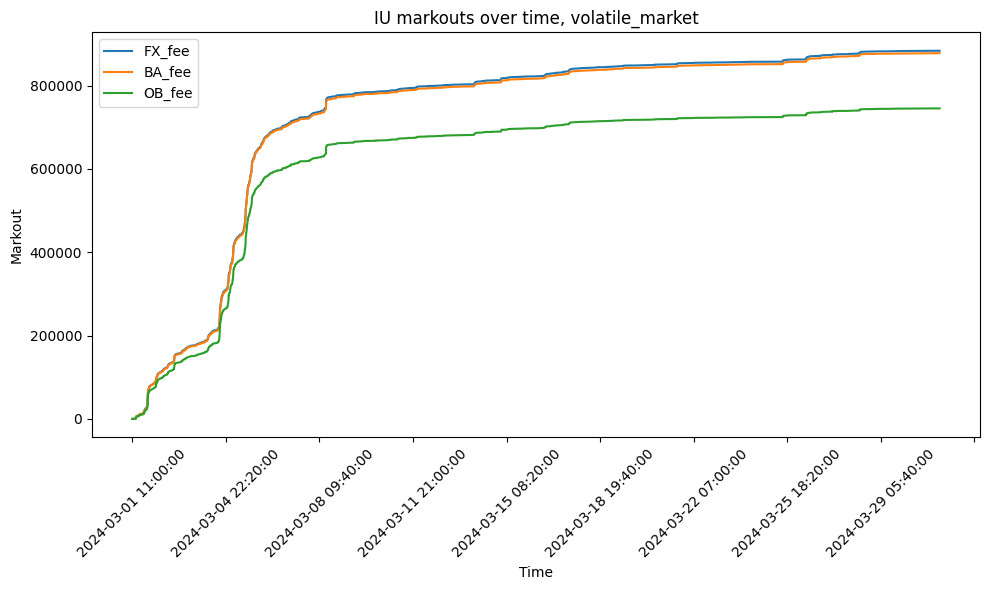

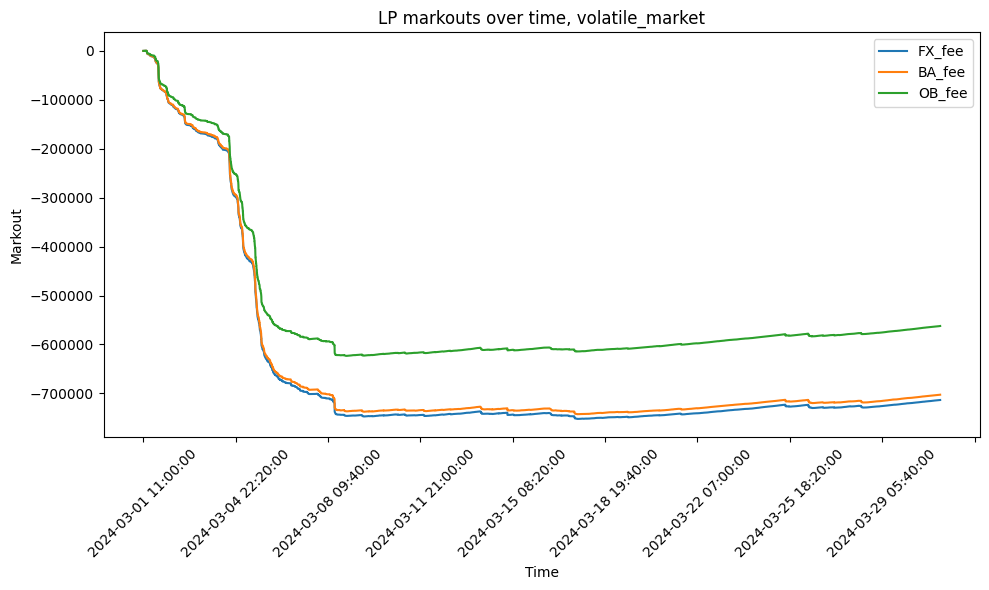

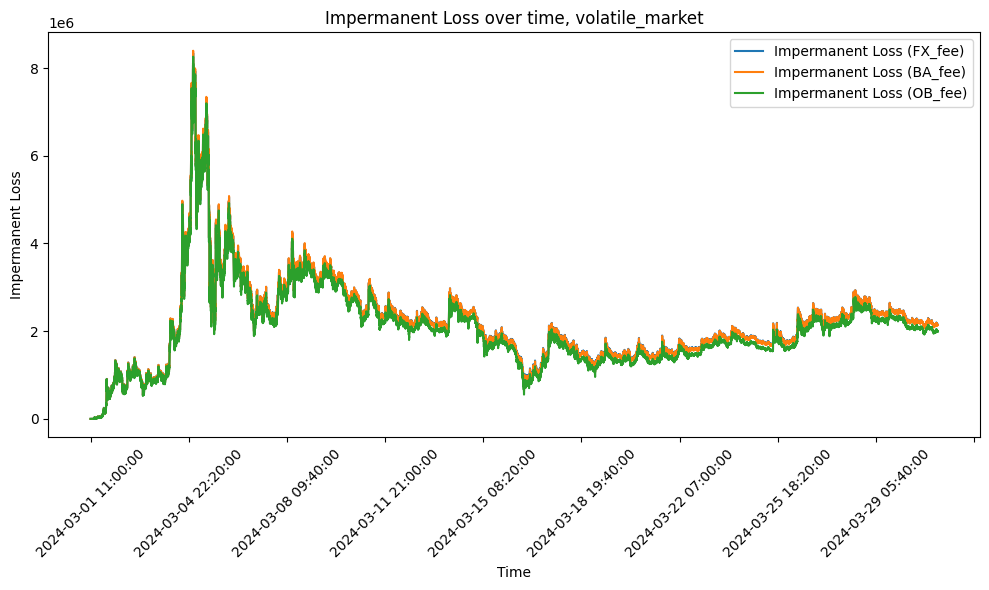

,experiment_name,iu_markout,iu_trade_count,iu_yield,uu_markout,uu_trade_count,uu_yield,lp_markout,lp_yield,impermanent_loss
0,FX_fee,883899.75,7421,33.73,-314528.43,21415,-47.49,-713551.32,-21.74,2146636.20
1,BA_fee,878087.52,7320,33.81,-319057.25,21421,-48.19,-702735.26,-21.56,2140245.48
2,OB_fee,745470.74,5563,35.83,-318140.83,21426,-48.03,-562274.91,-20.50,1995396.68


In [14]:
volatile_market_summary = plot_results_for_period("volatile_market", list(fee_algos_to_consider.keys()))

### All results

In [26]:
import pandas as pd
from visualizations.compare_fee_algoritms import get_experiments_summary_by_description

combined_df = get_experiments_summary_by_description(
    experiment_results,
).sort_values(by=["period_alias", "fee_algorithm"])

combined_df = combined_df.set_index(['period_alias'])


for col in combined_df.columns:
    need_rounding = False
    if 'markout' in col:
        need_rounding = True
    if 'impermanent_loss' in col:
        need_rounding = True
    if need_rounding:
        combined_df[col] = combined_df[col].round()

combined_df = combined_df.drop(
    columns=[
        "iu_trade_count",
        "uu_trade_count",
        # "uu_yield",
        # "iu_yield",
    ]
)

display(combined_df)

,fee_algorithm,iu_markout,iu_yield,uu_markout,uu_yield,lp_markout,lp_yield,impermanent_loss
period_alias,,,,,,,,
bear_market,BA_fee,63082.0,20.66,-222168.0,-59.21,44126.0,6.48,-181757.0
bear_market,FX_fee,63222.0,20.63,-221017.0,-59.09,43210.0,6.35,-183518.0
bear_market,OB_fee,53033.0,23.61,-222757.0,-59.46,58254.0,9.72,-192818.0
bull_market,BA_fee,180639.0,18.81,-269788.0,-51.25,-36721.0,-2.47,-505210.0
bull_market,FX_fee,183885.0,18.83,-272720.0,-51.53,-37780.0,-2.51,-497942.0
bull_market,OB_fee,148360.0,20.07,-271359.0,-51.43,2720.0,0.21,-541723.0
calm_market,BA_fee,21557.0,12.86,-222936.0,-60.70,86584.0,16.19,-130465.0
calm_market,FX_fee,21547.0,13.23,-222801.0,-60.79,86924.0,16.42,-129736.0
calm_market,OB_fee,17768.0,14.58,-223127.0,-60.91,93014.0,19.05,-135422.0


In [21]:
combined_df.to_markdown()

'| period_alias    | fee_algorithm   |   iu_markout |   iu_trade_count |   iu_yield |   uu_markout |   uu_trade_count |   uu_yield |   lp_markout |   lp_yield |   impermanent_loss |\n|:----------------|:----------------|-------------:|-----------------:|-----------:|-------------:|-----------------:|-----------:|-------------:|-----------:|-------------------:|\n| bear_market     | BA_fee          |        63082 |             2208 |      20.66 |      -222168 |            20784 |     -59.21 |        44126 |       6.48 |  -181757           |\n| bear_market     | FX_fee          |        63222 |             2199 |      20.63 |      -221017 |            20718 |     -59.09 |        43210 |       6.35 |  -183518           |\n| bear_market     | OB_fee          |        53033 |             1538 |      23.61 |      -222757 |            20756 |     -59.46 |        58254 |       9.72 |  -192818           |\n| bull_market     | BA_fee          |       180639 |             4392 |      18.81 |     

In [17]:
### Just more readable visualization of same df

# Round the DataFrame to 2 decimal places
df = combined_df.reset_index().round(2)  # Ensure the index levels are retained as columns

# Styling function for alternating background colors and bold text
def highlight_periods(row):
    unique_periods = df['period_alias'].unique()  # Access the 'period_alias' column
    colors = [
        'background-color: #f2f2f2;',  # Light gray
        'background-color: #d9eaf7;',  # Pastel blue
        'background-color: #eaf7d9;',  # Pastel green
        'background-color: #fff6cc;',  # Pastel yellow
    ]
    group_index = list(unique_periods).index(row['period_alias'])
    return [colors[group_index % len(colors)]] * len(row)

def make_numbers_bold(val):
    """Make all numeric values bold."""
    if isinstance(val, (int, float, str)):
        return 'font-weight: bold; color: #000;'
    return ''  # No styling for non-numeric values

# Format numbers to 2 decimal places
def format_numbers(val):
    """Ensure all numeric values are formatted to 2 decimal places."""
    if isinstance(val, (int, float)):
        return f'{val:.2f}'
    return val

# Apply alternating background colors, bold styling, and number formatting
styled_df = (
    df.style
    .apply(highlight_periods, axis=1)
    .applymap(make_numbers_bold)
    .format(format_numbers)  # Apply number formatting
)

styled_df

/var/folders/6m/j_3_5lz50ydghfntgxlrt8br0000gq/T/ipykernel_87891/1815749587.py:35: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(make_numbers_bold)


,period_alias,fee_algorithm,iu_markout,iu_trade_count,iu_yield,uu_markout,uu_trade_count,uu_yield,lp_markout,lp_yield,impermanent_loss
0,bear_market,BA_fee,63081.51,2208.00,20.66,-222167.81,20784.00,-59.21,44126.30,6.48,-181757.01
1,bear_market,FX_fee,63221.84,2199.00,20.63,-221016.89,20718.00,-59.09,43210.05,6.35,-183518.44
2,bear_market,OB_fee,53033.05,1538.00,23.61,-222756.76,20756.00,-59.46,58253.71,9.72,-192817.69
3,bull_market,BA_fee,180638.61,4392.00,18.81,-269787.73,20782.00,-51.25,-36720.88,-2.47,-505209.70
4,bull_market,FX_fee,183885.20,4459.00,18.83,-272719.97,20864.00,-51.53,-37780.23,-2.51,-497942.00
5,bull_market,OB_fee,148359.50,3243.00,20.07,-271359.24,20813.00,-51.43,2719.73,0.21,-541722.54
6,calm_market,BA_fee,21556.81,1449.00,12.86,-222935.93,21510.00,-60.70,86584.12,16.19,-130465.17
7,calm_market,FX_fee,21547.33,1388.00,13.23,-222801.41,21478.00,-60.79,86924.08,16.42,-129736.31
8,calm_market,OB_fee,17768.01,1016.00,14.58,-223127.23,21453.00,-60.91,93014.22,19.05,-135422.48
9,volatile_market,BA_fee,878087.52,7320.00,33.81,-319057.25,21421.00,-48.19,-702735.26,-21.56,2140245.48


### Fee based on trade count state

In [32]:
from experiments.experiment import ExperimentResult
from utility import fix_x_axis_labels
from typing import Optional
from pool.liquidity_state import PoolLiquidityState

def plot_fee_based_on_trade_count_fee_history(experiment_result: ExperimentResult, fee_algo_name: str, first_updates: Optional[int] = None):
    all_snapshots = experiment_result.simulation_result.snapshots
    if first_updates is not None:
        all_snapshots = all_snapshots[:first_updates]

    a_to_b_fees = []
    b_to_a_fees = []
    
    
    for snapshot in all_snapshots:
        a_to_b_fees.append(snapshot.pool.fee_algorithm.a_to_b_exchange_fee_rate)
        b_to_a_fees.append(snapshot.pool.fee_algorithm.b_to_a_exchange_fee_rate)

    all_timestamps = experiment_result.simulation_result.timestamps
    if first_updates is not None:
        all_timestamps = all_timestamps[:first_updates]

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(all_timestamps, a_to_b_fees, label=f"{A_symbol} to {B_symbol} exchange fee rate")
    ax.plot(all_timestamps, b_to_a_fees, label=f"{B_symbol} to {A_symbol} exchange fee rate")
    ax.set_xlabel("Time")
    ax.set_ylabel("Exchange fee rate")
    ax.legend(loc="upper right")
    plt.title(f"Exchange fee rate over time for {fee_algo_name} algorithm, volatile market")

    fix_x_axis_labels(ax)

    plt.xticks(rotation=45)

    plt.show()

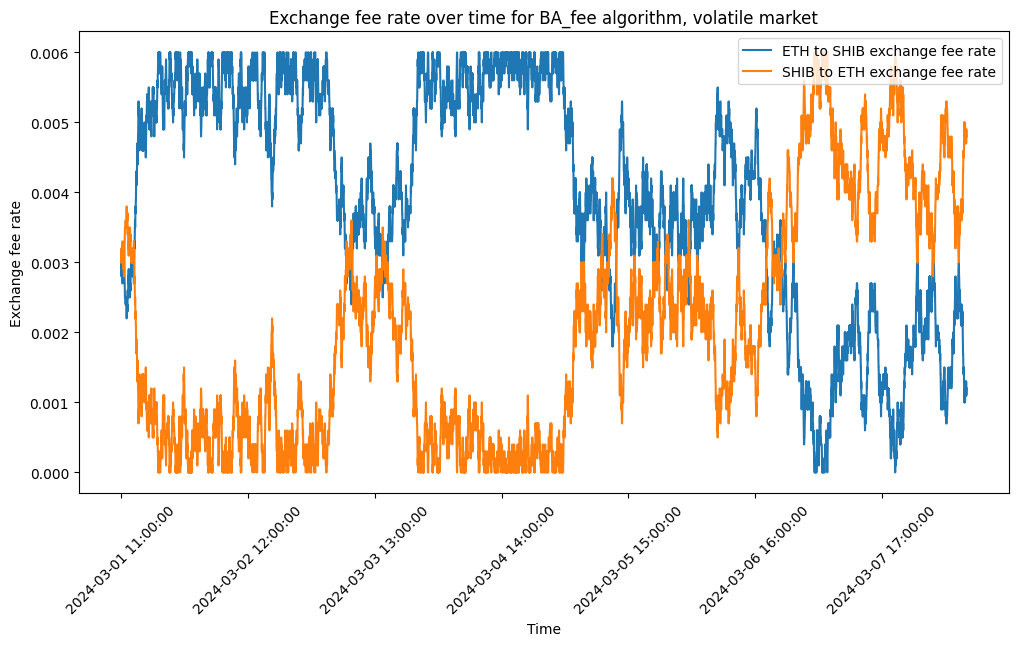

In [33]:
plot_fee_based_on_trade_count_fee_history(
    experiment_results[
        get_experiment_key(
            {
                "period_alias": "volatile_market",
                "fee_algorithm": "BA_fee",
            }
        )
    ],
    "BA_fee",
    10000,
)

In [ ]:
plot_fee_based_on_trade_count_fee_history(
    experiment_results[
        get_experiment_key(
            {
                "period_alias": "volatile_market",
                "fee_algorithm": "adaptive_based_on_previous_block_price_move_fee",
            }
        )
    ],
    "adaptive fee based on previous block price move",
    3000,
)